In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Organize data into train, valid, test dirs

os.chdir('../Cats and Dogs/PetImages/train')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [3]:
train_path = '../Cats and Dogs/PetImages/train/train'
valid_path = '../Cats and Dogs/PetImages/train/valid'
test_path = '../Cats and Dogs/PetImages/train/test'

In [4]:
# create batches from the train, valid, and test directories
# ImageDataGenerator.flow_from_directory() creates a DirectoryIterator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

# specify the target_size of the images, which will resize all images to the specified size
# The size we specify here is determined by the input size that the neural network expects.

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


A DirectoryIterator is an infinitely repeating dataset. In future code we'll have to use steps_per_epoch parameter or else the fit method will get stuck in an infinite loop.

### Visualize the data

In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

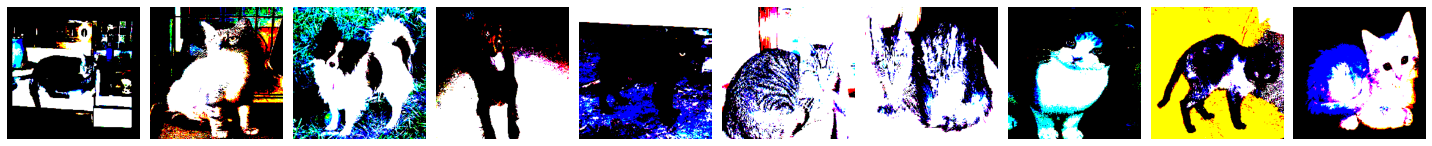

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

### Build a simple CNN

In [14]:
model = Sequential([
    # first layer is 2-dimensional convolutional layer w/ 32 output filters
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2), 
    # second 2D convolutional layer with 64 filters
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2), Flatten(), 
    # final layer has 2 outputs for dog and cat
    Dense(units=2, activation='softmax')])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [16]:
# compile the model using the Adam optimizer with learning rate 0.0001

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# fit the model

model.fit(x=train_batches,
          # s_p_e is set to len(train_batches) which equals 100 - block #4: 1000 images / 10 batches = 100
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          # epochs is set to 10 - 10 epochs * 100 images per batch = 1000 images
          epochs=10,
          # verbose is simply how the output will be displayed
          verbose=2)

Epoch 1/10
100/100 - 37s - loss: 13.5113 - accuracy: 0.5850 - val_loss: 5.7508 - val_accuracy: 0.6350
Epoch 2/10
100/100 - 33s - loss: 2.0828 - accuracy: 0.7840 - val_loss: 3.6606 - val_accuracy: 0.6350
Epoch 3/10
100/100 - 34s - loss: 0.7302 - accuracy: 0.8860 - val_loss: 3.4428 - val_accuracy: 0.6700
Epoch 4/10
100/100 - 33s - loss: 0.1437 - accuracy: 0.9650 - val_loss: 3.5470 - val_accuracy: 0.6500
Epoch 5/10
100/100 - 33s - loss: 0.0863 - accuracy: 0.9750 - val_loss: 3.2859 - val_accuracy: 0.6500
Epoch 6/10
100/100 - 34s - loss: 0.0099 - accuracy: 0.9950 - val_loss: 3.1109 - val_accuracy: 0.6450
Epoch 7/10
100/100 - 33s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.9945 - val_accuracy: 0.6500
Epoch 8/10
100/100 - 33s - loss: 4.4401e-04 - accuracy: 1.0000 - val_loss: 2.9370 - val_accuracy: 0.6650
Epoch 9/10
100/100 - 34s - loss: 2.5913e-04 - accuracy: 1.0000 - val_loss: 2.9362 - val_accuracy: 0.6650
Epoch 10/10
100/100 - 34s - loss: 2.1895e-04 - accuracy: 1.0000 - val_loss: 2.9478

With the train accuracy at 100% and the validation accuracy only at 66% we can see the model is overfitting

### Preparing test data

In [18]:
# extract images and labels from the test set

test_imgs, test_labels = next(test_batches)

### Making predictions on test data

In [20]:
predictions = model.predict(x=test_batches,
                            # similar to step_per_epoch
                            # len(test_batches) = 10, batch size = 100, it'll make 10 prediction runs
                            steps=len(test_batches),
                            verbose=0)

In [21]:
# view predictions using the round() function since the outputs aren't exactly 1 or 0

np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [22]:
# a confusion matrix (using scikit-learn) will provide a better visualization

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [26]:
# define function to print and plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix w/o Normalization')
    print(cm)    
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [24]:
# check class_indices to know which order to pass the labels in the matrix

test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion Matrix w/o Normalization
[[34 16]
 [17 33]]


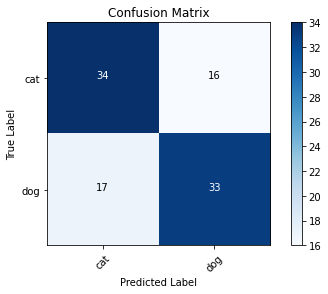

In [27]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

The model correctly predicted:
- the image was a cat 34 times
- the image was a dog 33 times

The model incorrectly predicted:
- the image was a cat 17 times
- the image was a dog 16 times

*Accuracy = correct classifications / total items*
- 67/100 = 0.67 accuracy

*Recall (sensitivity) = true positive / (true negative + false negative)*
- 34/(17 + 16) = 1.03 cat recall
- 33/(16 + 17) = 1.00 dog recall

*Specificity (true negative rate) = true negative / (true negative + false positive)*
- 17/(17 + 16) = 0.52 cat specificity
- 16/(16 + 17) = 0.48 dog specificity

*Precision = true positive / (true positive + false positive)*
- 34/(34 + 17) = 0.67 cat precision
- 33/(33 + 16) = 0.67 dog precision

*F1 = (2 * precision * recall) / (precision + recall)*
- (2 * 0.67 * 1.03)/(0.67 + 1.03) = 0.81
- (2 * 0.67 * 1.00)/(0.67 + 1.00) = 0.80